# Investigating the difference in selection criteria.

The original criteria for Hu et. al., (2019) were:

1) S/N (N964) > 5 in the narrow band for 2" exposures and S/N (N

## Scaling based on exposure time

\begin{align}
\frac{(S/N)^H}{(S/N)^T} &= \sqrt{\frac{t_{H}}{t_{T}}} \\ 
\Rightarrow (S/N)^H &= (S/N)^T \sqrt{\frac{t_{H}}{t_{T}}}
\end{align}



In [1]:
from dataclasses import dataclass
import numpy as np
import pylab as plt

from sex_catalog import SExtractorCat
from zero_points import zero_points
from zero_points_cdfs import zero_points_cdfs


def calc_snr(mag_err):
    return (2.5/np.log(10))/mag_err

def add_mag_info(sextractor_catalog:str, zero_point):
    cat = SExtractorCat(sextractor_catalog)
    cat.catalog['MAG_CORR'] = cat.catalog['MAG_APER'] + zero_point
    cat.catalog['SNR'] = calc_snr(cat.catalog['MAGERR_APER'])
    plt.scatter(cat.catalog['MAG_CORR'][cat.catalog['MAG_CORR'] < 100], cat.catalog['SNR'][cat.catalog['MAG_CORR'] < 100])
    plt.show()
    return cat

def get_mags_at_snr(cat: SExtractorCat, snr):
    mags = list(cat.catalog[(cat.catalog['SNR']>snr-0.1) & (cat.catalog['SNR']<snr+0.1)]['MAG_CORR'])
    return mags

def get_mags_at_sigma_val(infile_us, infile_cdfs, zpt_us, zpt_cdfs, snr):
    cat_t = add_mag_info(infile_us, zpt_us)
    cat_h = add_mag_info(infile_cdfs, zpt_cdfs)
    mag_t = get_mags_at_snr(cat_t, snr)
    mag_h = get_mags_at_snr(cat_h, snr)
    return mag_t, mag_h


## Histograming the region around 5 sigma.

In [2]:
@dataclass 
class Settings:
    our_catalog_name: str
    cdfs_catalog_name: str
    our_zpt: float
    cdfs_zpt: float
    snr_limit: float


def run(settings: Settings):
    
    mags_t, mags_h = get_mags_at_sigma_val(
                settings.our_catalog_name,
                settings.cdfs_catalog_name,
                settings.our_zpt,
                settings.cdfs_zpt,
                settings.snr_limit)
    our_mag_cut = np.nanmedian(mags_t)
    their_mag_cut = np.nanmedian(mags_h)
    print('Mag cut for at: ', our_mag_cut)
    print('Mag cut cdfs: ', their_mag_cut)
    print(len(mags_h))
    print()
    bins = np.arange(24,28,0.01)
    plt.hist(mags_h, bins=bins, label='Hu')
    plt.hist(mags_t, bins=bins, label='Lambert')
    plt.axvline(our_mag_cut, ls='--', color='k')
    plt.axvline(their_mag_cut, ls=':', color='k')
    plt.legend()
    plt.show()
    

In [3]:

narrow_band_settings = Settings(
    '../correct_stacks/N964/n964.cat',
    '../CDFS_LAGER/n964_cdfs.cat',
    zero_points.n964_band.mag_correct(1),
    zero_points_cdfs.n964_band.mag_correct(1),
    5)

narrow_band_135_settings = Settings(
    '../correct_stacks/N964/n964_135.cat',
    '../CDFS_LAGER/n964_135_cdfs.cat',
    zero_points.n964_band.mag_correct(1),
    zero_points_cdfs.n964_band.mag_correct(1),
    5)

i_band_settings = Settings(
    '../correct_stacks/N964/i.cat',
    '../CDFS_LAGER/i_cdfs_depth.cat',
    zero_points.i_band.mag_correct(1),
    zero_points_cdfs.i_band.mag_correct(1),
    5)

z_band_settings = Settings(
    '../correct_stacks/N964/z.cat',
    '../CDFS_LAGER/z_cdfs_depth.cat',
    zero_points.z_band.mag_correct(1),
    zero_points_cdfs.z_band.mag_correct(1),
    5)

n


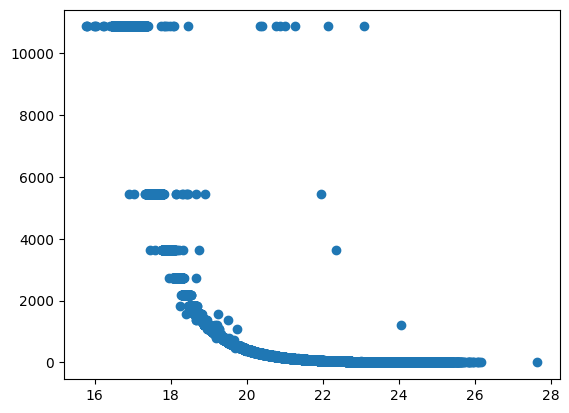

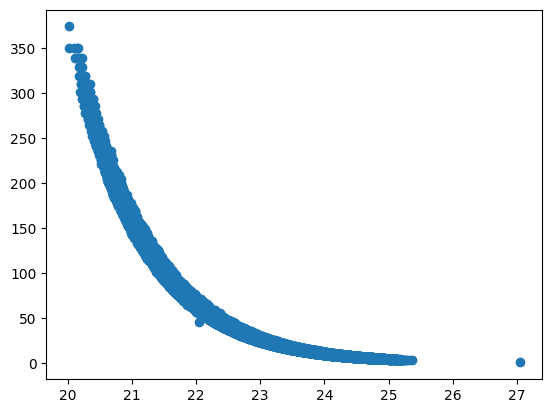

Mag cut for at:  24.69683013511129
Mag cut cdfs:  24.80203133973219
1220



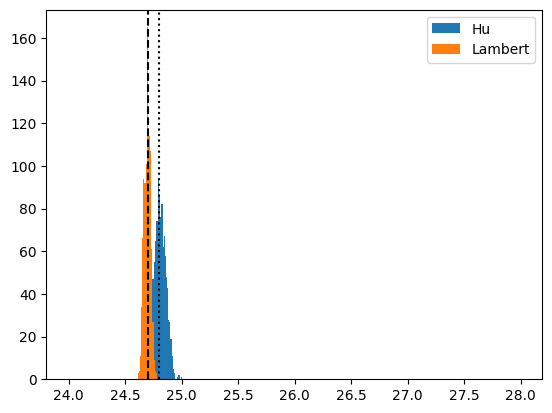

n_135


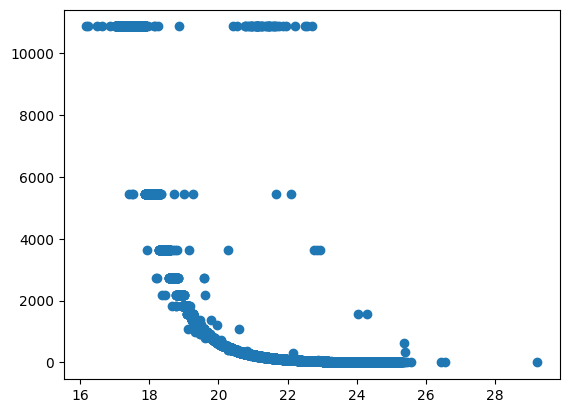

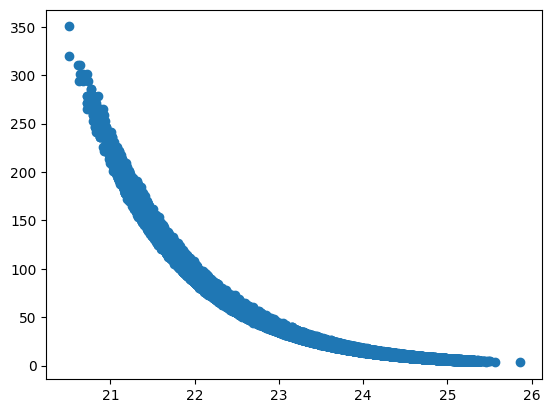

Mag cut for at:  25.090930135111293
Mag cut cdfs:  25.22053133973219
338



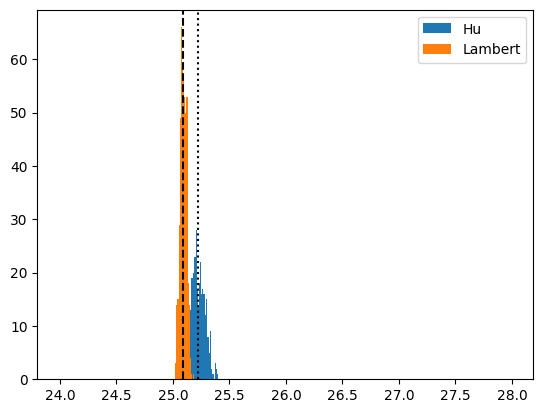

z


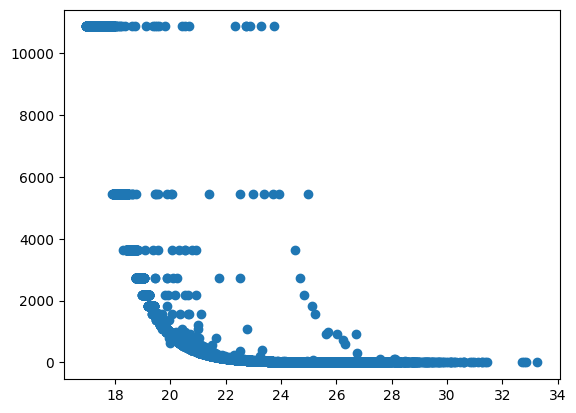

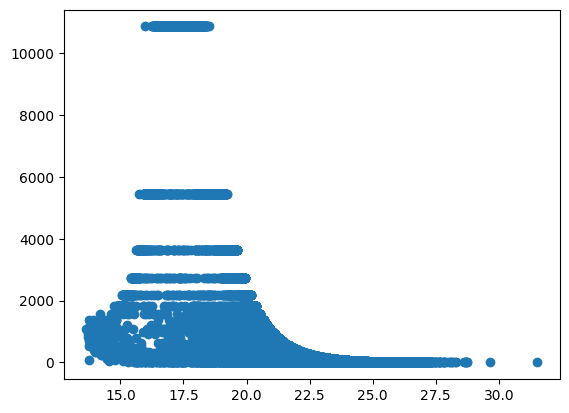

Mag cut for at:  25.611226650512332
Mag cut cdfs:  26.72247060089064
1271



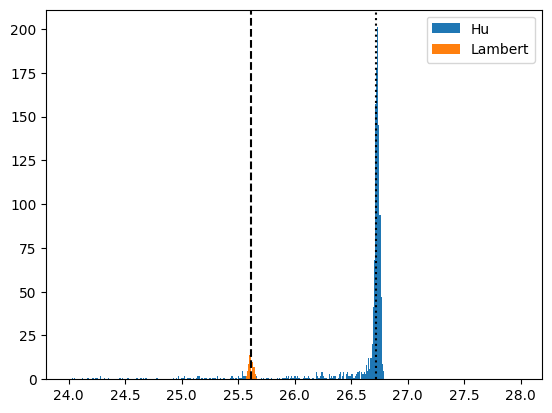

i


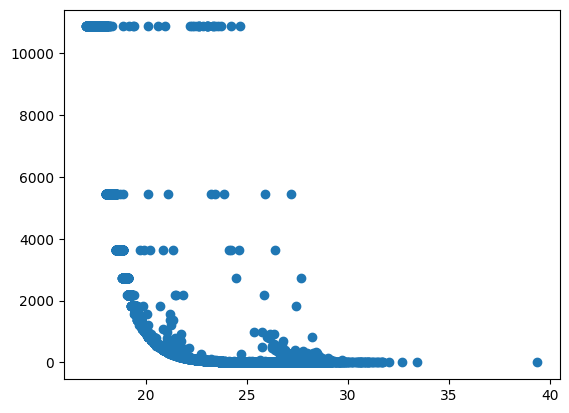

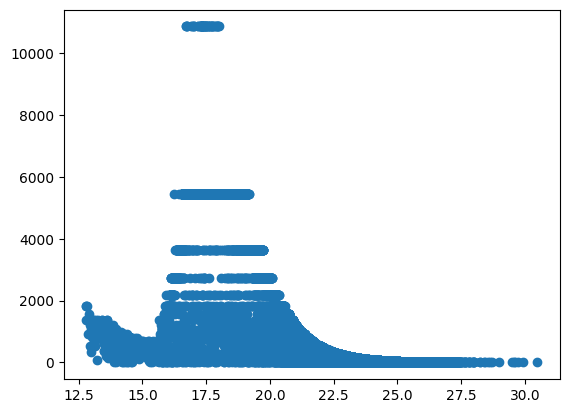

Mag cut for at:  25.67933036248649
Mag cut cdfs:  27.004148088911357
881



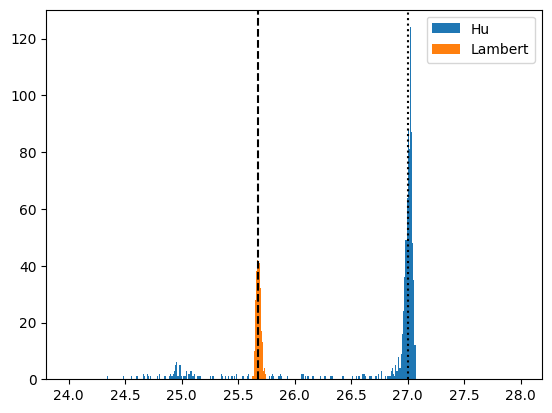

In [4]:
print('n')
run(narrow_band_settings)
print('n_135')
run(narrow_band_135_settings)
print('z')
run(z_band_settings)
print('i')
run(i_band_settings)

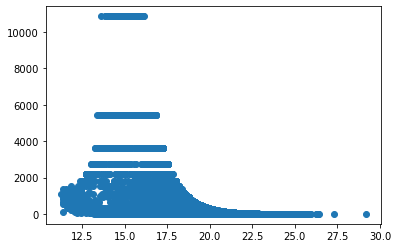

1271


In [5]:
catalog = add_mag_info('../CDFS_LAGER/z_cdfs_depth.cat', zero_points_cdfs.n964_band.mag_correct(1))
reduced_cat = catalog.catalog[(catalog.catalog['SNR'] > 4.9) & (catalog.catalog['SNR'] < 5.1)]
ra, dec = reduced_cat['ALPHAPEAK_J2000'], reduced_cat['DELTAPEAK_J2000']
ra, dec = np.array(ra), np.array(dec)
print(len(ra))

In [6]:
from identify_candidates_v2 import write_region_file
write_region_file(ra, dec, 'TEST_DELETE.reg', 4)